## Barcamp2024 - Modelo para predecir variacion de peso corporal usando Deep Learning.

Este es un modelo de ejemplo que se desarrollara en este notebook para luego desplegarlo a un ambiente de produccion usando ONNX. Haremos 2 versiones de un mismo modelo: Una en Tensorflow (Google) y otra en PyTorch (Meta) y veremos como usando un mismo runtime con ONNX podremos ejecutarlo independientemente de la libreria donde lo hayamos elaborado.

URL del dataset: https://www.kaggle.com/datasets/abdullah0a/comprehensive-weight-change-prediction

### Descripcion de las variables del dataset:

- **participant_id:** Identificador unico de cada participante del estudio
- **age:** La edad del participante (en años), el cual puede influenciar el metabolismo y el cambio de peso.
- **gender:** Genero del participante (M/F), ya que las diferencias fisiologicas podrian afectar el manejo del peso.
- **current_weight (lbs):** El peso del participante al inicio del estudio, sirviendo como base de comparacion para la variacion de peso.
- **bmr (Calories):** Tasa Metabolica Basal, calculado usando la ecuacion de Mifflin-St Jeor, representando el numero de calorias quemadas en reposo.
- **daily_calories_consumed:** consumo calorico total por dia, incluyendo la variabilidad para reflejar habitos alimenticios del mundo real.
- **daily_caloric_surplus_deficit:** La diferencia entre calorias consumidas y el BMR, indicando si el participante esta en un superavit calorico o en un deficit calorico.
- **weight_change (lbs):** El cambio de peso estimado sobre una duracion especificada, basada en un superavit o deficit calorico.
- **duration (weeks):** El periodo de tiempo sobre el cual se mide el cambio de peso, que varia entre 1 a 12 semanas.
- **physical_activity_level:** Nivel de actividad fisica auto-reportado, categorizado como Sedentario (Sedentary), Ligeramente Activo (Lightly Active), Moderadamente Activo (Moderately Active), o Muy Activo (Very Active.
- **sleep_quality:** Calidad del sueño auto-reportada, categorizada como Pobre (Poor), Regular (Fair), Buena (Good), o Excelente (Excellent), el cual puede afectar el manejo del peso.
- **stress_level:** Un puntaje numerico (1-10) indicando el nivel de stress percibido por el participante, ya que el stress puede influenciar habitos alimenticios y el peso.

In [1]:
import numpy as np
import pandas as pd
import sklearn

# Config adicionales para pandas
pd.set_option('display.max_columns', None)

# Importando dataset.
dataset_path = '../Dataset/weight_change_dataset.csv'

dataset_data = pd.read_csv(dataset_path)
dataset_data = dataset_data.drop(['participant_id'], axis=1)
dataset_data.head(10)


,age,gender,current_weight,bmr,daily_calories_consumed,daily_caloric_surplus_deficit,weight_change,duration,physical_activity_level,sleep_quality,stress_level
0,56,M,228.4,3102.3,3916.0,813.7,0.200000,1,Sedentary,Excellent,6
1,46,F,165.4,2275.5,3823.0,1547.5,2.400000,6,Very Active,Excellent,6
2,32,F,142.8,2119.4,2785.4,666.0,1.400000,7,Sedentary,Good,3
3,25,F,145.5,2181.3,2587.3,406.0,0.800000,8,Sedentary,Fair,2
4,38,M,155.5,2463.8,3312.8,849.0,2.000000,10,Lightly Active,Good,1
5,56,F,152.9,2100.6,2262.4,161.9,-12.513498,9,Sedentary,Poor,6
6,36,M,107.3,1991.3,2933.4,942.1,-2.437307,2,Moderately Active,Poor,5
7,40,M,207.9,2977.9,4000.0,1022.1,-35.678115,11,Moderately Active,Poor,9
8,28,F,169.5,2406.9,3890.2,1483.4,-8.476633,10,Very Active,Poor,1
9,28,F,169.2,2403.3,2485.8,82.5,0.000000,2,Sedentary,Excellent,7


## Describiendo los datos

Observando las propiedades estadisticas de los datos.

In [2]:
# Describiendo el dataset en la parte numerica.
dataset_data.describe()

,age,current_weight,bmr,daily_calories_consumed,daily_caloric_surplus_deficit,weight_change,duration,stress_level
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,37.910000,171.533000,2518.206000,3518.292000,1000.091000,-2.779817,6.920000,4.810000
std,12.219454,30.333856,364.431221,513.313097,371.560827,7.443719,3.515277,2.576879
min,18.000000,100.000000,1566.500000,2030.900000,82.500000,-35.678115,1.000000,1.000000
25%,26.750000,153.650000,2255.050000,3233.300000,766.950000,-5.012312,4.000000,2.750000
50%,38.000000,172.150000,2519.500000,3636.050000,1013.100000,0.100000,7.000000,5.000000
75%,46.250000,192.475000,2805.975000,4000.000000,1253.325000,1.850000,10.000000,7.000000
max,59.000000,238.200000,3390.800000,4000.000000,1922.500000,5.000000,12.000000,9.000000


In [3]:
# Funcionalidad para verificar la distribucion de los datos.
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches

def skewed_distribution(data, features, title):
    figure = pl.figure(figsize = (11,5))
    for i, feature in enumerate(features):
        ax = figure.add_subplot(1, 4, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s'"%(feature), fontsize = 14)
        ax.set_xlabel("Valor")
        ax.set_ylabel("Numero de registros")
        ax.set_ylim((0, 140))
        ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140])
        ax.set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, ">140"])
        figure.suptitle(title, fontsize = 16, y = 1.03)
        figure.tight_layout()
    
    

## Distribucion de los features

Aqui veremos la distribucion de los features con la desviacion estandar mas alta para saber que tan sesgados estan y asi realizar ajustes de los mismos durante el feature engineering.

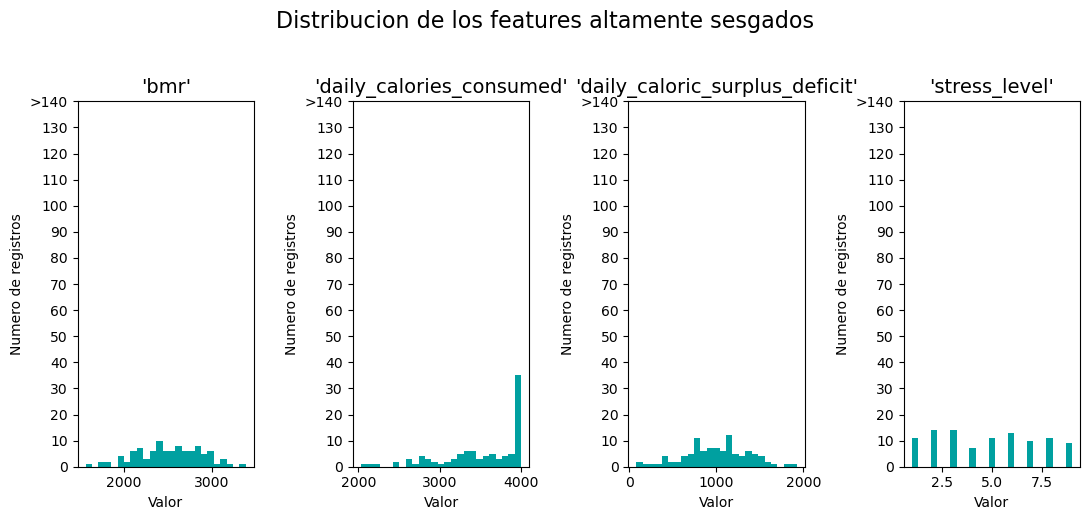

In [4]:
features_to_check = ['bmr', 'daily_calories_consumed', 'daily_caloric_surplus_deficit', 'stress_level']
plot_title = "Distribucion de los features altamente sesgados"
skewed_distribution(dataset_data, features_to_check, plot_title)

Por lo visto **daily_calories_consumed** es un feature que esta altamente sesgado a la izquierda y por tanto habrá que transformarlo para que se comporte como una distribucion normal (Gauss)

## Feature engineering.

En este paso generaremos los features que el modelo usara para poder entrenarse. Esto incluye:

- Separacion de los features de la variable objetivo (la variable que queremos predecir).

In [5]:
# Separacion de la variable objetivo del resto de features.
variacion_peso = dataset_data['weight_change']

# Separacion de los features de la variable objetivo.
features_data = dataset_data.drop('weight_change', axis = 1)
pred_pipeline_data = features_data.copy()

## Pre-procesamiento.

En este paso vamos a pre-procesar los features para que el modelo/algoritmo de deep learning pueda entrenarse de la manera correcta y pueda producir predicciones de la forma mas integra posible. Esto incluye:

- Transformacion de los features numericos altamente sesgados.
- Normalizacion de los features numericos.
- Transformacion de los features categoricos a features numericos.

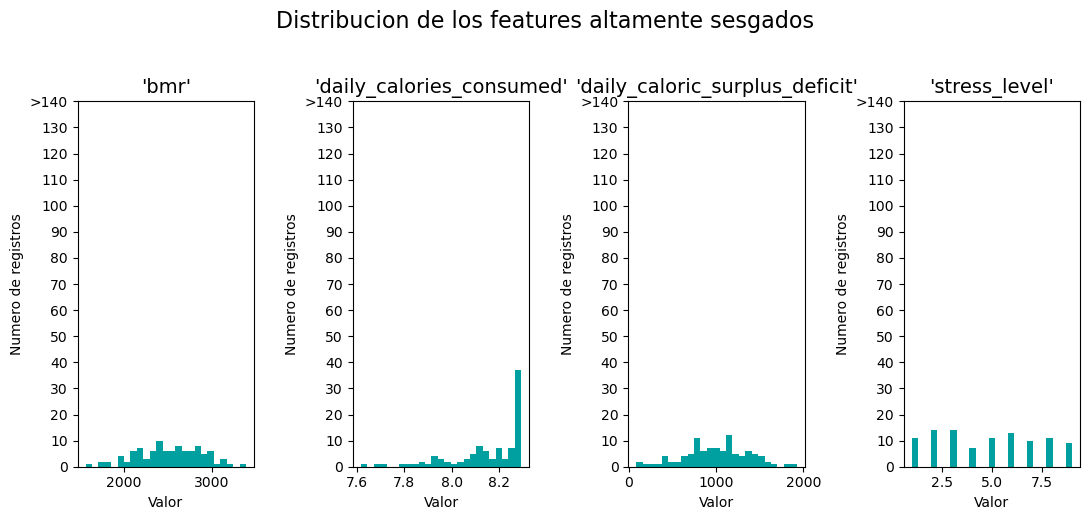

In [6]:
from sklearn.preprocessing import MinMaxScaler

features_sesgados = ['daily_calories_consumed']
features_data[features_sesgados] = dataset_data[features_sesgados].apply(lambda x: np.log(x + 1))
skewed_distribution(features_data, features_to_check, plot_title)

In [7]:
# Normalizacion de los features numericos.

scaler = MinMaxScaler()
features_numericos = ['age', 'current_weight', 'bmr', 'daily_calories_consumed', 'daily_caloric_surplus_deficit', 'duration', 'stress_level']
features_data[features_numericos] = scaler.fit_transform(dataset_data[features_numericos])
features_data.head(1)

,age,gender,current_weight,bmr,daily_calories_consumed,daily_caloric_surplus_deficit,duration,physical_activity_level,sleep_quality,stress_level
0,0.926829,M,0.929088,0.841857,0.957341,0.397391,0.0,Sedentary,Excellent,0.625


In [8]:
# Transformacion de features categoricos a numericos (One-Hot Encoding)

features = pd.get_dummies(features_data, dtype='int')
features

,age,current_weight,bmr,daily_calories_consumed,daily_caloric_surplus_deficit,duration,stress_level,gender_F,gender_M,physical_activity_level_Lightly Active,physical_activity_level_Moderately Active,physical_activity_level_Sedentary,physical_activity_level_Very Active,sleep_quality_Excellent,sleep_quality_Fair,sleep_quality_Good,sleep_quality_Poor
0,0.926829,0.929088,0.841857,0.957341,0.397391,0.000000,0.625,0,1,0,0,1,0,1,0,0,0
1,0.682927,0.473227,0.388642,0.910111,0.796196,0.454545,0.625,1,0,0,0,0,1,1,0,0,0
2,0.341463,0.309696,0.303075,0.383170,0.317120,0.545455,0.250,1,0,0,0,1,0,0,0,1,0
3,0.170732,0.329233,0.337006,0.282566,0.175815,0.636364,0.125,1,0,0,0,1,0,0,1,0,0
4,0.487805,0.401592,0.491860,0.651008,0.416576,0.818182,0.000,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.000000,0.592619,0.579017,0.825402,0.516793,0.090909,0.250,0,1,1,0,0,0,1,0,0,0
96,0.926829,0.119392,0.093186,0.368493,0.509511,1.000000,1.000,1,0,0,1,0,0,0,0,1,0
97,0.975610,0.453690,0.341008,0.667005,0.583315,1.000000,0.750,1,0,1,0,0,0,0,1,0,0
98,0.658537,0.577424,0.605931,1.000000,0.676957,0.363636,0.500,0,1,0,1,0,0,0,1,0,0


## Creando modelo de deep learning.

Ya con la data debidamente preparada y pre-procesada, ahora crearemos nuestro modelo de deep learning, una Deep Neural Network (DNN) tradicional para problemas de regresion ya que inicialmente la variable a predecir/estimar es una variable numerica continua (weight_change que es la del cambio de peso).

Inicialmente usaremos TensorFlow y luego utilizaremos PyTorch para entrenar el mismo modelo en 2 librerias distintas con fines a ver la diferencia entre el deployment a produccion de forma tradicional con los mecanismos de cada herramienta y luego haciendolo con ONNX.

Primero tendremos que crear los training_set, validation_set y test_set.

In [9]:
import tensorflow as tf
from preprocessing_pipelines import RegPredictionDataPrep
from sklearn.model_selection import train_test_split

def pre_process_data_point(data_point, highly_skewed_features, numerical_features):
    '''
    Pre-process adequately a data point we want to predict
    Args: data_point (dictionary object with the features we want to make a prediction on)
    '''
    data_point_df = pd.DataFrame(data_point, index=[0])
    data_point_df_copy = data_point_df

    # Aplicando logaritmo natural a features altamente sesgados.
    data_point_df[highly_skewed_features] = data_point_df[highly_skewed_features].apply(lambda x: np.log(x + 1))

    # Escalando los features para que tengan igual tratamiento
    feat_scaler = MinMaxScaler()
    data_point_df[numerical_features] = feat_scaler.fit_transform(data_point_df_copy[numerical_features])
    print("Data")
    print(data_point_df)
    print("END Data")

    # Convirtiendo los features categoricos en features numericos.
    data_point_df = pd.get_dummies(data_point_df, dtype='int')
    

    return data_point_df
    

# Split dataset into train, validation and tests sets
def split_dataset(X_data, Y_data, dataset_size, pct_validation, pct_test):

    X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=pct_validation)
    X_train2, X_test, Y_train2, Y_test = train_test_split(X_train, Y_train, test_size=pct_test)

    return X_train2, X_val, X_test, Y_train2, Y_val, Y_test


features_train, features_val, features_test, target_train, target_val, target_test = split_dataset(features, variacion_peso, len(features), 0.15, 0.15)

print(f"Features train length: %s " % len(features_train))
print(f"Features validation length: %s " % len(features_val))
print(f"Features test length: %s " % len(features_test))

# Converting splitted dataset to tensors for the DNN.

t_features_train = tf.convert_to_tensor(features_train)
t_features_val = tf.convert_to_tensor(features_val)
t_features_test = tf.convert_to_tensor(features_test)

t_target_train = tf.convert_to_tensor(target_train)
t_target_val = tf.convert_to_tensor(target_val)
t_target_test = tf.convert_to_tensor(target_test)

# Testing pre-processing function.
sample_data_point = {
    "age": 23,
    "gender": "M",
    "current_weight": 155,
    "bmr": 2500.0,
    "daily_calories_consumed": 3600.0,
    "daily_caloric_surplus_deficit": 50.0,
    "duration": 75.0,
    "stress_level": 70,
    "physical_activity_level": "Sedentary",
    "sleep_quality": "Excellent"
}

data_point_highly_skewed_features = ['daily_calories_consumed']
data_point_numerical_features = ['age', 'current_weight', 'bmr', 'daily_calories_consumed', 'daily_caloric_surplus_deficit', 'duration', 'stress_level']

features_names = list(features.keys())
prediction_pipeline = RegPredictionDataPrep(pred_pipeline_data, data_point_highly_skewed_features, data_point_numerical_features, features_names)

sample_pre_processed_datapoint = prediction_pipeline.parse_features(sample_data_point)


2025-03-22 19:19:07.875662: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Features train length: 72 
Features validation length: 15 
Features test length: 13 


## Creando y entrenando el modelo.

Procederemos a crear una DNN (Deep Neural Network) para fines de regresion.

In [10]:
# Creando el modelo
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(17,)))
model.add(tf.keras.layers.Dense(15, activation='tanh'))
model.add(tf.keras.layers.Dense(7, activation='tanh'))
model.add(tf.keras.layers.Dense(1, activation='linear', name='output'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 15)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390 (1.52 KB)

 Trainable params: 390 (1.52 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compilando el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['r2_score'])


model_epochs = 250
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights.best.from_scratch.keras', verbose=1, save_best_only=True)

model.fit(t_features_train, t_target_train, validation_data=(t_features_val, t_target_val), epochs=model_epochs, batch_size=10, callbacks=[checkpoint], verbose=1)

Epoch 1/250
1/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 8.6053 - r2_score: -0.0301
Epoch 1: val_loss improved from inf to 104.73937, saving model to weights.best.from_scratch.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 39.4395 - r2_score: -0.1195 - val_loss: 104.7394 - val_r2_score: -0.3628
Epoch 2/250
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 32.3804 - r2_score: -0.0105
Epoch 2: val_loss improved from 104.73937 to 102.07235, saving model to weights.best.from_scratch.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 51.4320 - r2_score: -0.1651 - val_loss: 102.0723 - val_r2_score: -0.3281
Epoch 3/250
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 53.7903 - r2_score: -0.2879
Epoch 3: val_loss improved from 102.07235 to 99.64245, saving model to weights.best.from_scratch.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 53.5799 - r2_score: -0.1856 - val_loss: 99.6424 - val_r2_score: -0.2964
Epoch 4/250
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 15.8180 - r2_score: 0.018

In [12]:
tensor_preprocessed_datapoint = tf.convert_to_tensor(sample_pre_processed_datapoint)
print(tensor_preprocessed_datapoint)
prediction = model.predict(tensor_preprocessed_datapoint)
print(prediction)

tf.Tensor(
[[ 0.12195122  0.39797395  0.51170312 -1.0272263  -0.01766304  6.72727273
   8.625       0.          1.          0.          0.          1.
   0.          1.          0.          0.          0.        ]], shape=(1, 17), dtype=float64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
[[-9.372835]]


## Exportando modelo de Tensorflow para servirlo en produccion.

Aqui exportamos el modelo ya entrenado para poderlo servir en produccion usando TensorFlow Serving. Usaremos `model.export` para que se pueda salvar en el formato SavedModel de Tensorflow el cual es el formato soportado por TensorFlow Serving

In [13]:
model.output_names = ['output']
model.export('barcamp2024-model-tensorflow/1')

INFO:tensorflow:Assets written to: barcamp2024-model-tensorflow/1/assets


INFO:tensorflow:Assets written to: barcamp2024-model-tensorflow/1/assets


Saved artifact at 'barcamp2024-model-tensorflow/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 17), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  5543462672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5543461520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5543461904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5543464016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5543461712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5543462864: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Entrenando modelo de deep learning con PyTorch

Ahora entrenaremos la misma red neuronal con los datos ya pre-procesados pero con la libreria PyTorch de Meta.

Primero procederemos a crear la clase que albergara la red neuronal asi como la clase que formateara el dataset al esquema que utiliza PyTorch

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader

class DeepNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(17, 15),
            nn.Tanh(),
            nn.Linear(15,7),
            nn.Tanh(),
            nn.Linear(7,1)
        )
    def forward(self, x):
        return self.layers(x)

class WeightVariationDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.tensor(X.values)
            self.y = torch.tensor(y.values)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

## Preparacion de dataset de PyTorch

Preparando el dataset con la clase WeightVariationDataset. Utilizaremos los datos previamente pre-procesados que utilizamos en la etapa con TensorFlow

In [15]:
# Preparando el dataset previamente pre-procesado (no haremos nuevos preprocesamiento)
weight_change_dataset = WeightVariationDataset(features_train, target_train)
trainloader = torch.utils.data.DataLoader(weight_change_dataset, batch_size=10, shuffle=True, num_workers=0)

## Inicializando y entrenando modelo.

In [16]:
torch_model = DeepNeuralNetwork()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(torch_model.parameters(), lr=1e-4)

# Usaremos 250 epochs para el entrenamiento al igual que TF
for epoch in range(0, 250):
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    current_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
  
        # Zero the gradients
        optimizer.zero_grad()
  
        # Perform forward pass
        outputs = torch_model(inputs)
  
        # Compute loss
        loss = loss_function(outputs, targets)
  
        # Perform backward pass
        loss.backward()
  
        # Perform optimization
        optimizer.step()
  
        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / 500))
            current_loss = 0.0

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 0.076
Starting epoch 2
Loss after mini-batch     1: 0.070
Starting epoch 3
Loss after mini-batch     1: 0.022
Starting epoch 4
Loss after mini-batch     1: 0.172
Starting epoch 5
Loss after mini-batch     1: 0.049
Starting epoch 6
Loss after mini-batch     1: 0.150
Starting epoch 7
Loss after mini-batch     1: 0.114
Starting epoch 8
Loss after mini-batch     1: 0.196
Starting epoch 9
Loss after mini-batch     1: 0.072
Starting epoch 10
Loss after mini-batch     1: 0.175
Starting epoch 11
Loss after mini-batch     1: 0.135
Starting epoch 12
Loss after mini-batch     1: 0.114
Starting epoch 13
Loss after mini-batch     1: 0.028
Starting epoch 14
Loss after mini-batch     1: 0.020
Starting epoch 15
Loss after mini-batch     1: 0.174
Starting epoch 16
Loss after mini-batch     1: 0.149
Starting epoch 17
Loss after mini-batch     1: 0.187
Starting epoch 18
Loss after mini-batch     1: 0.167
Starting epoch 19
Loss after mini-batch     1: 0.053
St

## Haciendo predicciones con el modelo en PyTorch

En este apartado haremos predicciones con el modelo hecho en PyTorch. Primero colocaremos el modelo en modo evaluacion con la funcion `.eval()` que permitirá que el modelo salga del modo de entrenamiento y pase al modo evaluacion. Luego deshabilitaremos el calculo de gradientes mediante `torch.no_grad()`

In [17]:
# Utilizando el mismo datapoint pre-procesado que utilizamos en tensorflow para la prediccion, crearemos
# un tensor de PyTorch.

torch_prediction_input = torch.tensor(sample_pre_processed_datapoint.values, dtype=torch.float32)

torch_model.eval()

with torch.no_grad():
    prediction = torch_model(torch_prediction_input)

print("Prediction: ", (prediction).float().item())

Prediction:  -2.181509494781494


## Salvando el modelo de PyTorch para servirlo a produccion usando TorchServe

Salvamos los pesos (weights) del modelo en un archivo `.pth` que luego sera convertido a un modelo `.mar` el cual es el archivo soportado por TorchServe. Para crear el archivo `.pth` usaremos la funcion `torch.save()`

In [18]:
torch.save(torch_model.state_dict(), 'barcamp2024-model-pytorch.pth')

## Convirtiendo modelos a formato ONNX.

In [19]:
import tf2onnx

# Tensorflow.
tf_spec = [tf.TensorSpec.from_tensor(tensor_preprocessed_datapoint)]
tf_output_path = 'barcamp2024-model-tensorflow.onnx'

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=tf_spec, opset=15, output_path=tf_output_path)
torch_output_path = 'barcamp2024-model-pytorch.onnx'

# PyTorch
# nn_inputs=['age', 'gender', 'bmr', 'daily_calories_consumed', 'daily_caloric_surplus_deficit', 'duration', 'stress_level', 'gender_F', 'gender_M', 'physical_activity_level_Lightly Active', 'physical_activity_level_Sedentary', 'physical_activity_level_Very Active', 'sleep_quality_Excellent', 'sleep_quality_Fair', 'sleep_quality_Good', 'sleep_quality_Poor']
nn_inputs=['modelInput']
torch.onnx.export(torch_model, torch_prediction_input, torch_output_path, opset_version=13, input_names=nn_inputs, output_names=['modelOutput'])

I0000 00:00:1742685813.409601 4722971 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1742685813.476855 4722971 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
